This notebook is meant to establish a baseline score for what all our other models should aim to achieve. Using just rankings as our features, our logistic regression model will learn to pick the higher ranked team when determining the results of matchups. 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%tensorflow_version 2.x
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split #for train_test_split
import tensorflow as tf #import tensorflow
from tensorflow.keras import layers, optimizers #import tensorflow
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
print(tf.__version__)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0-rc3


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
season_compact = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
season_compact = season_compact[season_compact['Season'] > 2002]
season = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv")
rankings = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MMasseyOrdinals.csv")
teams = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MTeams.csv")

rankings = rankings.groupby(['Season', 'TeamID', 'SystemName']).mean().drop(columns=['RankingDayNum'])


rankings.reset_index(inplace=True)

pom_rankings = rankings[rankings['SystemName'] == 'POM' ].drop(columns=['SystemName']).rename(columns={'OrdinalRank' : 'POM'})
sag_rankings = rankings[rankings['SystemName'] == 'SAG' ].drop(columns=['SystemName']).rename(columns={'OrdinalRank' : 'SAG'})
mor_rankings = rankings[rankings['SystemName'] == 'MOR' ].drop(columns=['SystemName']).rename(columns={'OrdinalRank' : 'MOR'})


sel_rankings = pd.concat((pom_rankings, sag_rankings, mor_rankings))

sel_rankings = sel_rankings.groupby(['Season', 'TeamID']).mean()

sel_rankings = sel_rankings.reset_index()

sel_rankings

,Season,TeamID,POM,SAG,MOR
0,2003,1102,140.266667,128.800000,128.200000
1,2003,1103,179.333333,183.666667,155.000000
2,2003,1104,26.533333,28.000000,22.800000
3,2003,1105,311.666667,310.133333,297.600000
4,2003,1106,237.533333,254.733333,270.600000
...,...,...,...,...,...
5828,2019,1462,76.052632,65.684211,79.789474
5829,2019,1463,89.578947,99.263158,95.631579
5830,2019,1464,293.052632,295.684211,280.052632
5831,2019,1465,211.947368,283.789474,260.894737


In [5]:
sel_rankings['Season'] = sel_rankings['Season'].astype(str)
sel_rankings['TeamID'] = sel_rankings['TeamID'].astype(str)

season_compact['Season'] = season_compact['Season'].astype(str)
season_compact['WTeamID'] = season_compact['WTeamID'].astype(str)
season_compact['LTeamID'] = season_compact['LTeamID'].astype(str)

season_compact = season_compact.merge(sel_rankings, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop(columns=['TeamID'])
season_compact = season_compact.merge(sel_rankings, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop(columns=['TeamID'])

wins = pd.DataFrame()
wins['Season'] = season_compact['Season']
wins['WTeamID'] = season_compact['WTeamID']
wins['LTeamID'] = season_compact['LTeamID']
wins['DayNum'] = season_compact['DayNum']

wins['POM'] = season_compact['POM_x'] - season_compact['POM_y']
wins['SAG'] = season_compact['SAG_x'] - season_compact['SAG_y']
wins['MOR'] = season_compact['MOR_x'] - season_compact['MOR_y']

wins['Result'] = 1

loss = pd.DataFrame()
loss['Season'] = season_compact['Season']
loss['WTeamID'] = season_compact['WTeamID']
loss['LTeamID'] = season_compact['LTeamID']
loss['DayNum'] = season_compact['DayNum']

loss['POM'] = season_compact['POM_y'] - season_compact['POM_x']
loss['SAG'] = season_compact['SAG_y'] - season_compact['SAG_x']
loss['MOR'] = season_compact['MOR_y'] - season_compact['MOR_x']

loss['Result'] = 0

all_games = pd.concat((wins, loss)).dropna()

all_games

,Season,WTeamID,LTeamID,DayNum,POM,SAG,MOR,Result
0,2003,1104,1328,10,10.800000,6.733333,16.600000,1
1,2003,1272,1393,10,27.333333,21.200000,7.533333,1
2,2003,1266,1437,11,-34.466667,-40.600000,-17.466667,1
3,2003,1296,1457,11,-83.400000,-61.800000,-74.666667,1
4,2003,1400,1208,11,-7.066667,-10.733333,-2.933333,1
...,...,...,...,...,...,...,...,...
87499,2019,1153,1222,132,-5.368421,0.842105,-4.631579,0
87500,2019,1209,1426,132,88.684211,43.368421,64.736842,0
87501,2019,1277,1276,132,0.842105,3.263158,5.052632,0
87502,2019,1387,1382,132,48.578947,56.000000,33.315789,0


In [6]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

for stat in ['POM', 'MOR', 'SAG']:
  all_games[stat] = scaler.fit_transform(all_games[stat].values.reshape(-1,1))

all_games

,Season,WTeamID,LTeamID,DayNum,POM,SAG,MOR,Result
0,2003,1104,1328,10,0.031329,0.019589,0.048050,1
1,2003,1272,1393,10,0.079288,0.061678,0.021806,1
2,2003,1266,1437,11,-0.099981,-0.118119,-0.050559,1
3,2003,1296,1457,11,-0.241926,-0.179796,-0.216128,1
4,2003,1400,1208,11,-0.020499,-0.031227,-0.008491,1
...,...,...,...,...,...,...,...,...
87499,2019,1153,1222,132,-0.015573,0.002450,-0.013406,0
87500,2019,1209,1426,132,0.257255,0.126173,0.187386,0
87501,2019,1277,1276,132,0.002443,0.009494,0.014625,0
87502,2019,1387,1382,132,0.140917,0.162922,0.096435,0


In [0]:
all_games.to_csv('/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/RankingsTrain.csv')

In [0]:
#Create train and test sets for the logistic regression, naive bayes, and random forest
#This creates our train and test sets for our logistic regression, naive bayes, and random forest models. 
all_games = all_games.sample(frac=1)
train = all_games[0:140000]
test = all_games[140000:]
parameters = train[['POM', 'MOR', 'SAG']].values
labels = train[['Result']].values
test_params = test[['POM', 'MOR', 'SAG']].values
test_labels = test[['Result']].values

In [9]:
#Logistic Regression Model
log_reg = LogisticRegression(random_state=0).fit(parameters, labels)

target_pred = log_reg.predict(test_params)
target_proba = log_reg.predict_proba(test_params)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)

print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.746562392574768
LogLoss:  0.5064958745341392


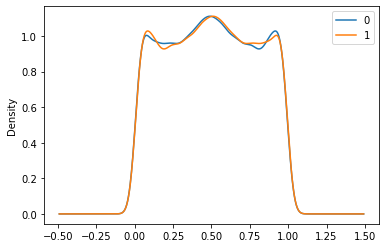

In [10]:
probabilities = pd.DataFrame(target_proba)
probabilities.plot.kde()